# Model LGBM

# 0. Setup

# >>> fillna for demand in fulldf!

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import geohash

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from rdforecast import datasets

path = './input/'
data = datasets.load_training_data()
print('TAZ:', len(data['geohash6'].unique()))
data = datasets.convert_datetime(data)
data.head()

'filepath' not given, download data from: https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
Data loaded.
N: 4206321
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
TAZ: 1329


geohash6  day timestamp    demand       date      time            datetime
0   qp03wc   18      20:0  0.020072 2018-01-19  20:00:00 2018-01-19 20:00:00
1   qp03pn   10     14:30  0.024721 2018-01-11  14:30:00 2018-01-11 14:30:00
2   qp09sw    9      6:15  0.102821 2018-01-10  06:15:00 2018-01-10 06:15:00
3   qp0991   32       5:0  0.088755 2018-02-02  05:00:00 2018-02-02 05:00:00
4   qp090q   15       4:0  0.074468 2018-01-16  04:00:00 2018-01-16 04:00:00

In [4]:
ts = data['timestamp'].unique()
h, m = zip(*[t.split(':') for t in ts])
h = np.array([int(i) for i in h])
m = np.array([(int(i) / 60) for i in m])
ts_num = h + m
ts_to_num = dict(zip(ts, ts_num))
data['timestamp'] = data['timestamp'].map(ts_to_num)

In [5]:
data['timestep'] = data['time'].apply(lambda x: (x.hour * 60 + x.minute) / 15) + (data['day'] - 1) * 96
data['dow'] = data['day'] % 7
data['weekly'] = data['timestep'] % 672

In [6]:
weekly = data[['geohash6', 'weekly', 'demand']].groupby(['geohash6', 'weekly']).mean().unstack()
weekly.columns = weekly.columns.levels[1]
weekly.fillna(0, inplace=True)
# weekly['active_count'] = weekly.index.map(counts) / max_count
# weekly['active_count'] = weekly.index.map(counts)
weekly.head()

weekly       0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0       8.0    \
geohash6                                                                        
qp02yc    0.010381    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.008417   
qp02yf    0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
qp02yu    0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
qp02yv    0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
qp02yy    0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.010121   

weekly       9.0    ...  662.0  663.0  664.0  665.0  666.0  667.0     668.0  \
geohash6            ...                                                       
qp02yc    0.009744  ...    0.0    0.0    0.0    0.0    0.0    0.0  0.013851   
qp02yf    0.000000  ...    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
qp02yu    0.000000  ...    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
qp02yv    0.000000  ...    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   
qp02yy    0.000000  ...    0.0    0.0    0.0    0.0    0.0    0.0  0.000000   

weekly    669.0  670.0     671.0  
geohash6                          
qp02yc      0.0    0.0  0.010264  
qp02yf      0.0    0.0  0.000000  
qp02yu      0.0    0.0  0.000000  
qp02yv      0.0    0.0  0.000000  
qp02yy      0.0    0.0  0.000000  

[5 rows x 672 columns]

In [ ]:
from sklearn.metrics import silhouette_score
X = weekly.values
range_n_clusters = range(2,20)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters)
    res = km.fit(X)  
    silhouette_avg = silhouette_score(X, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

In [ ]:
SSE = []
for i in range(2,20):
    km = KMeans(n_clusters=i)
    res = km.fit(X)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,20), SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1,20)
plt.show()

In [8]:
from sklearn.cluster import KMeans

# define a function that does K-means clustering and plot the results
def plotKM(df, n_timesteps, n_features, n_clusters, tickstep=4, random_state=2019):
    print('Last feature:', df.columns[n_features - 1])
    
    # run K-means and assign results
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    res = km.fit(df.iloc[:, :n_features])
    df['label_km{}'.format(n_clusters)] = res.labels_
    
    # plot results
    plt.figure(figsize=(16,10))

    for l in range(n_clusters):
        # subset df and calculate means for each label
        df_ = df[df['label_km{}'.format(n_clusters)] == l]
        df_means = df_.mean(axis=0)
        
        plt.subplot(np.ceil(n_clusters/2), 2, 1+l)
        for i in range(len(df_)):
            plt.plot(range(n_timesteps), df_.iloc[i, :n_timesteps], 'steelblue', alpha=0.2)
            plt.plot(range(n_timesteps), df_means[:n_timesteps], 'indianred', linewidth=2)
        plt.xticks(np.arange(0, n_timesteps, tickstep), rotation=45)
        plt.title('KM Cluster Label: {} (n = {})'.format(l, len(df_)))

    plt.tight_layout()
    plt.show()

Last feature: 671.0


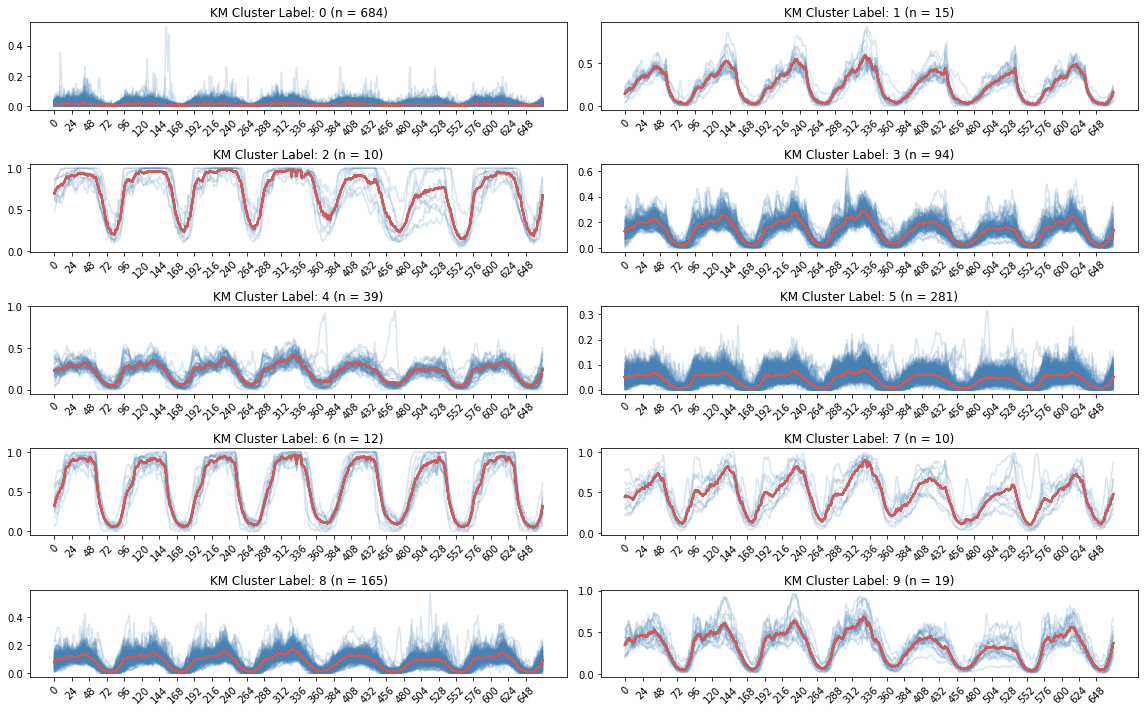

In [9]:
n_timesteps = 672
n_features = 672
plotKM(weekly, n_timesteps, n_features, 10, tickstep=24)

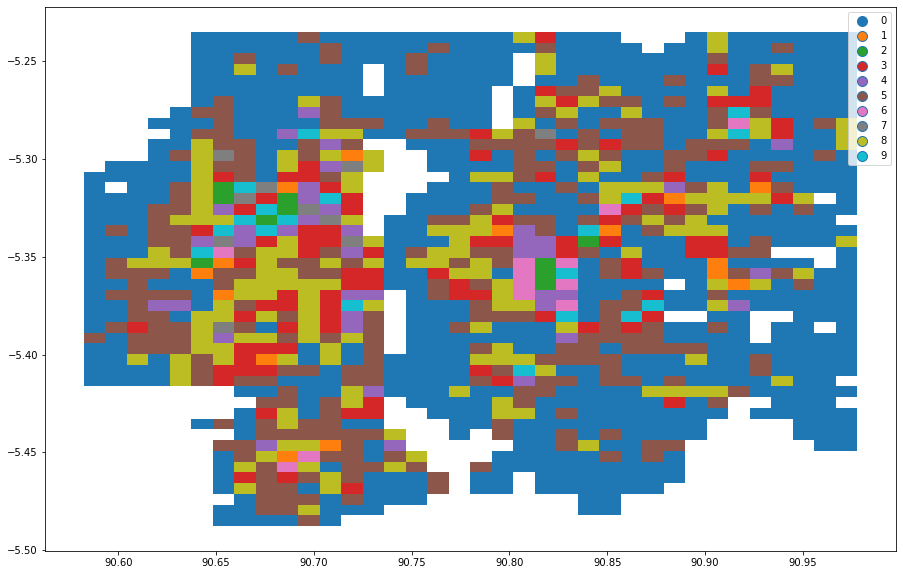

In [10]:
shp = gpd.read_file('input/taz.shp')
label_mapper = dict(zip(weekly.index, weekly['label_km10']))
shp['label'] = shp['geohash6'].map(label_mapper)
shp.plot(column='label', cmap='tab10', legend=True, categorical=True, figsize=(24,10));

In [11]:
counts = data['geohash6'].value_counts()
counts = dict(zip(counts.index, counts.values))
max_count = 61 * 24 * 4

def standardize_taz(df):
    tazmean = df.mean(axis=1)
    tazstd = df.std(axis=1)
    return df.apply(lambda x: (x - tazmean) / tazstd)

In [12]:
taz_daily = data.groupby(['geohash6', 'day'])['demand'].mean().reset_index()
taz_daily = taz_daily.pivot(index='geohash6', columns='day', values='demand')
taz_daily.fillna(0, inplace=True)
assert sum(taz_daily.sum(axis=1) == 0) == 0
taz_daily = standardize_taz(taz_daily)
taz_daily['active_count'] = taz_daily.index.map(counts) / max_count
taz_daily.head(1)

day              1         2         3        4         5         6         7  \
geohash6                                                                        
qp02yc   -1.373073  0.170734 -0.447731  0.06679 -0.465741 -0.557373  0.185095   

day              8         9        10  ...        53        54        55  \
geohash6                                ...                                 
qp02yc    0.100484 -0.164673 -1.158675  ...  0.400954  0.016292 -0.050179   

day             56        57        58        59        60        61  \
geohash6                                                               
qp02yc    0.264736 -0.038744 -0.060997  1.347398  0.512912  0.239749   

day       active_count  
geohash6                
qp02yc        0.098531  

[1 rows x 62 columns]

In [13]:
taz_quarterly = data.groupby(['geohash6', 'timestamp'])['demand'].mean().reset_index()
taz_quarterly = taz_quarterly.pivot(index='geohash6', columns='timestamp', values='demand')
taz_quarterly.fillna(0, inplace=True)
assert sum(taz_quarterly.sum(axis=1) == 0) == 0
taz_quarterly = standardize_taz(taz_quarterly)
taz_quarterly['active_count'] = taz_quarterly.index.map(counts) / max_count
taz_quarterly.head(1)

timestamp       0.0      0.25       0.5      0.75       1.0      1.25  \
geohash6                                                                
qp02yc     0.817159  0.050268 -1.099626 -0.366929  0.393077  1.279391   

timestamp      1.5      1.75       2.0      2.25  ...     21.75      22.0  \
geohash6                                          ...                       
qp02yc    -0.35927 -0.092664  1.007797  1.120308  ... -1.099626 -1.099626   

timestamp     22.25      22.5     22.75      23.0     23.25      23.5  \
geohash6                                                                
qp02yc    -0.755862 -0.469505  0.511916 -0.082454  0.710992 -0.599751   

timestamp     23.75  active_count  
geohash6                           
qp02yc    -0.005873      0.098531  

[1 rows x 97 columns]

Last feature: 61


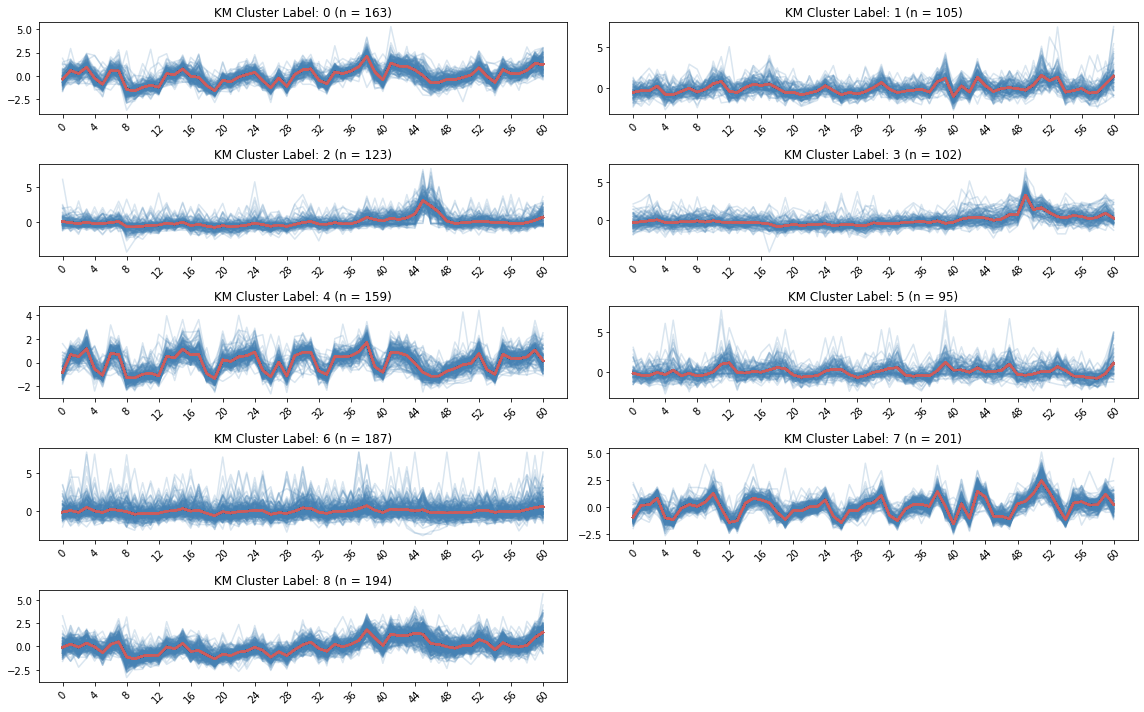

In [14]:
n_timesteps = 61
n_features = 61
plotKM(taz_daily, n_timesteps, n_features, 9)

Last feature: 23.75


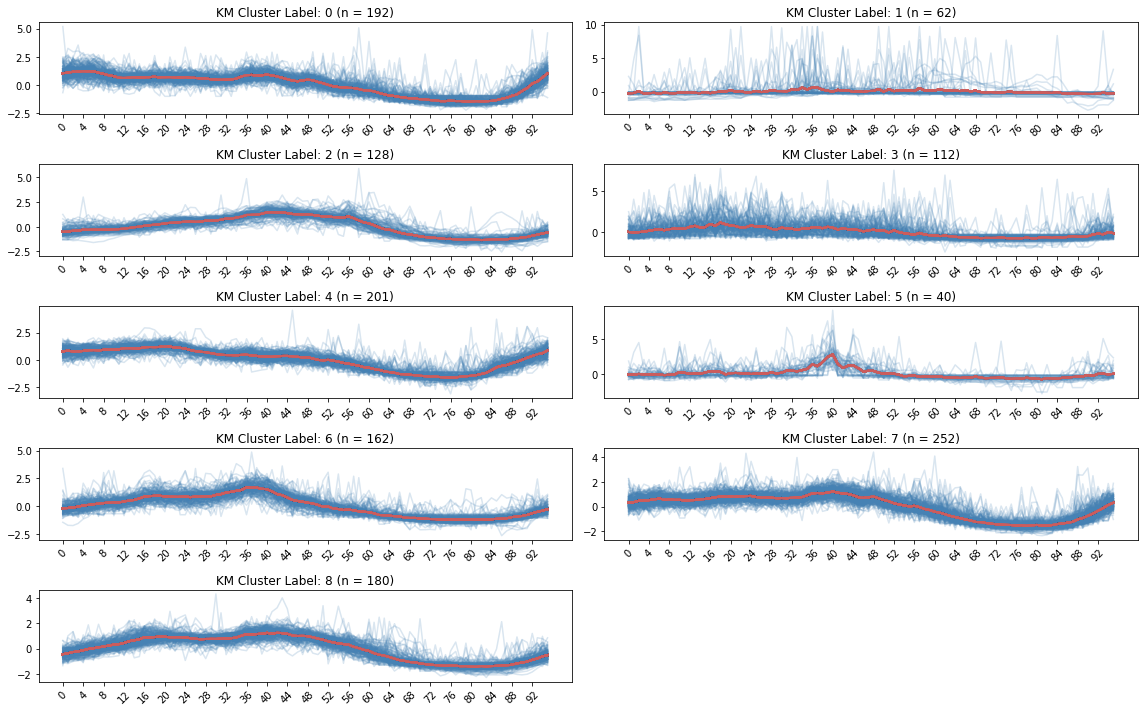

In [15]:
n_timesteps = 96
n_features = 96
plotKM(taz_quarterly, n_timesteps, n_features, 9)

# LightGBM

In [16]:
import lightgbm as lgb
def eval_RMSE(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    assert len(y_true) == len(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(rmse)
def eval_MAPE(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    print(mape)

In [17]:
data_ = data.merge(weekly[['label_km10']], how='left', left_on='geohash6', right_index=True)
data_ = data_.merge(taz_daily[['label_km9']], how='left', left_on='geohash6', right_index=True)
data_ = data_.merge(taz_quarterly[['label_km9']], how='left', left_on='geohash6', right_index=True)
data_['lon'], data_['lat'] = zip(*[(latlon[1], latlon[0]) for latlon in data_['geohash6'].map(geohash.decode)])
data_['hour'] = data_['time'].apply(lambda x: x.hour)
data_['count'] = data_['geohash6'].map(counts)
data_ = data_.sort_values(['geohash6', 'timestep'])
data_.head()

geohash6  day  timestamp    demand       date      time  \
2873712   qp02yc    1       2.75  0.020592 2018-01-02  02:45:00   
2643238   qp02yc    1       3.00  0.010292 2018-01-02  03:00:00   
1791986   qp02yc    1       4.00  0.006676 2018-01-02  04:00:00   
4022333   qp02yc    1       4.50  0.003822 2018-01-02  04:30:00   
3848343   qp02yc    1       6.75  0.011131 2018-01-02  06:45:00   

                   datetime  timestep  dow  weekly  label_km10  label_km9_x  \
2873712 2018-01-02 02:45:00      11.0    1    11.0           0            6   
2643238 2018-01-02 03:00:00      12.0    1    12.0           0            6   
1791986 2018-01-02 04:00:00      16.0    1    16.0           0            6   
4022333 2018-01-02 04:30:00      18.0    1    18.0           0            6   
3848343 2018-01-02 06:45:00      27.0    1    27.0           0            6   

         label_km9_y        lon       lat  hour  count  
2873712            7  90.653687 -5.484924     2    577  
2643238            7  90.653687 -5.484924     3    577  
1791986            7  90.653687 -5.484924     4    577  
4022333            7  90.653687 -5.484924     4    577  
3848343            7  90.653687 -5.484924     6    577

In [14]:
# # construct ckdtree
# from scipy.spatial import cKDTree
# tmp = data_.drop_duplicates(['geohash6'])[['lon', 'lat']]
# coords_lonlat = list(zip(tmp['lon'], tmp['lat']))
# tree = cKDTree(coords_lonlat)

# o_xy = list(zip(train_queries['o_x'], train_queries['o_y']))
# d_xy = list(zip(train_queries['d_x'], train_queries['d_y']))
# train_queries['nearest_station_o'] = tree.query(o_xy)[0]
# train_queries['nearest_station_d'] = tree.query(d_xy)[0]
# train_queries['nearby_stations_o'] = [len(s) for s in tree.query_ball_point(o_xy, r=900)]
# train_queries['nearby_stations_d'] = [len(s) for s in tree.query_ball_point(d_xy, r=900)]

In [18]:
max_ts = int(data_['timestep'].max())
timesteps = list(range(max_ts + 1))
full_df = pd.concat([pd.DataFrame({'geohash6': gh, 'timestep': timesteps}) for gh in data_['geohash6'].unique()])

taz_info = ['geohash6', 'label_km10', 'label_km9_x', 'label_km9_y', 'lon', 'lat', 'count']
ts_info = ['timestep', 'day', 'hour', 'dow', 'weekly']
demand_info = ['geohash6', 'timestep', 'demand']

full_df = full_df.merge(data_[taz_info].drop_duplicates(), how='left', on=['geohash6'])
full_df = full_df.merge(data_[ts_info].drop_duplicates(), how='left', on=['timestep'])
full_df.dropna(inplace=True)

# missing: 1671, 1672, 1673, 1678, 1679, 1680, 1681, 1682, 1683
# a = set(data_['timestep'].unique())
# b = set(timesteps)
# print(a.difference(b))
# print(b.difference(a))

full_df = full_df.merge(data_[demand_info].drop_duplicates(), how='left', on=['geohash6', 'timestep'])
full_df['demand'].fillna(0, inplace=True)
assert full_df['demand'].isna().sum().sum() == 0
full_df.head()

geohash6  timestep  label_km10  label_km9_x  label_km9_y        lon  \
0   qp02yc         0           0            6            7  90.653687   
1   qp02yc         1           0            6            7  90.653687   
2   qp02yc         2           0            6            7  90.653687   
3   qp02yc         3           0            6            7  90.653687   
4   qp02yc         4           0            6            7  90.653687   

        lat  count  day  hour  dow  weekly  demand  
0 -5.484924    577  1.0   0.0  1.0     0.0     0.0  
1 -5.484924    577  1.0   0.0  1.0     1.0     0.0  
2 -5.484924    577  1.0   0.0  1.0     2.0     0.0  
3 -5.484924    577  1.0   0.0  1.0     3.0     0.0  
4 -5.484924    577  1.0   1.0  1.0     4.0     0.0

In [19]:
def get_history(df, periods):
    tmp = pd.DataFrame.shift(df[['demand']], periods=periods)
    tmp.loc[~df['same_zone'], 'demand'] = -1
    df['demand_t-%s'%periods] = tmp
    df['demand_t-%s'%periods].fillna(-1, inplace=True)
    return df

In [20]:
tmp = [False]
tmp.extend(list(full_df['geohash6'][1:].values == full_df['geohash6'][:-1].values))
full_df['same_zone'] = tmp

full_df = get_history(full_df, 1)
full_df = get_history(full_df, 2)
full_df = get_history(full_df, 5)
full_df = get_history(full_df, 96)
full_df = get_history(full_df, 96*7)

In [21]:
full_df['am_peak'] = ((full_df['hour'] >= 22) | (full_df['hour'] <= 2)).astype(int)
full_df['midnight'] = ((full_df['hour'] >= 17) & (full_df['hour'] < 22)).astype(int)
full_df['weekend'] = (full_df['dow'] > 4).astype(int)
full_df['st_trend'] = full_df['demand_t-1'] - full_df['demand_t-2']
full_df['mt_trend'] = full_df['demand_t-2'] - full_df['demand_t-5']
full_df.head()

geohash6  timestep  label_km10  label_km9_x  label_km9_y        lon  \
0   qp02yc         0           0            6            7  90.653687   
1   qp02yc         1           0            6            7  90.653687   
2   qp02yc         2           0            6            7  90.653687   
3   qp02yc         3           0            6            7  90.653687   
4   qp02yc         4           0            6            7  90.653687   

        lat  count  day  hour  ...  demand_t-1  demand_t-2  demand_t-5  \
0 -5.484924    577  1.0   0.0  ...        -1.0        -1.0        -1.0   
1 -5.484924    577  1.0   0.0  ...         0.0        -1.0        -1.0   
2 -5.484924    577  1.0   0.0  ...         0.0         0.0        -1.0   
3 -5.484924    577  1.0   0.0  ...         0.0         0.0        -1.0   
4 -5.484924    577  1.0   1.0  ...         0.0         0.0        -1.0   

   demand_t-96  demand_t-672  am_peak  midnight  weekend  st_trend  mt_trend  
0         -1.0          -1.0        1         0        0       0.0       0.0  
1         -1.0          -1.0        1         0        0       1.0       0.0  
2         -1.0          -1.0        1         0        0       0.0       1.0  
3         -1.0          -1.0        1         0        0       0.0       1.0  
4         -1.0          -1.0        1         0        0       0.0       1.0  

[5 rows x 24 columns]

In [22]:
full_df.columns

Index(['geohash6', 'timestep', 'label_km10', 'label_km9_x', 'label_km9_y',
       'lon', 'lat', 'count', 'day', 'hour', 'dow', 'weekly', 'demand',
       'same_zone', 'demand_t-1', 'demand_t-2', 'demand_t-5', 'demand_t-96',
       'demand_t-672', 'am_peak', 'midnight', 'weekend', 'st_trend',
       'mt_trend'],
      dtype='object')

In [23]:
features = ['day', 'hour', 'timestep', 'dow', 'label_km9_x', 'label_km9_y', 'label_km10',
            'lon', 'lat', 'weekend', 'weekly', 'count',
            'demand_t-1', 'demand_t-5', 'demand_t-96', 'demand_t-672',
            'st_trend', 'mt_trend']
features.extend(['demand'])
X = full_df.dropna(subset=['day'])[features]
X.head()

day  hour  timestep  dow  label_km9_x  label_km9_y  label_km10        lon  \
0  1.0   0.0         0  1.0            6            7           0  90.653687   
1  1.0   0.0         1  1.0            6            7           0  90.653687   
2  1.0   0.0         2  1.0            6            7           0  90.653687   
3  1.0   0.0         3  1.0            6            7           0  90.653687   
4  1.0   1.0         4  1.0            6            7           0  90.653687   

        lat  weekend  weekly  count  demand_t-1  demand_t-5  demand_t-96  \
0 -5.484924        0     0.0    577        -1.0        -1.0         -1.0   
1 -5.484924        0     1.0    577         0.0        -1.0         -1.0   
2 -5.484924        0     2.0    577         0.0        -1.0         -1.0   
3 -5.484924        0     3.0    577         0.0        -1.0         -1.0   
4 -5.484924        0     4.0    577         0.0        -1.0         -1.0   

   demand_t-672  st_trend  mt_trend  demand  
0          -1.0       0.0       0.0     0.0  
1          -1.0       1.0       0.0     0.0  
2          -1.0       0.0       1.0     0.0  
3          -1.0       0.0       1.0     0.0  
4          -1.0       0.0       1.0     0.0

In [239]:
i = 4
X = X[X['label_km10'] == i] # 4, 6

In [24]:
X_train = X[X['day'] <= 47]
X_test = X[X['day'] > 47]

X_val = X_train[X_train['day'] > 40]
X_train = X_train[X_train['day'] <= 40]

y_train = X_train.pop('demand')
y_test = X_test.pop('demand')
y_val = X_val.pop('demand')

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(5091399, 18)
(893088, 18)
(1786176, 18)
(5091399,)
(893088,)
(1786176,)


In [25]:
X_train.loc[X_train.sample(frac=0.4).index, ['demand_t-1', 'st_trend']] = -1
X_train.loc[X_train.sample(frac=0.1).index, 'demand_t-5'] = -1

In [26]:
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression',
    'max_depth': 10,
    'min_data_in_leaf': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'rmse',
    'num_threads': 4
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = ['hour']

print("=" * 50)
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_vars)
dval = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_vars, reference=dtrain)
bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,
                valid_sets=[dtrain, dval], early_stopping_rounds=100, verbose_eval=50
)
print("\n".join(("%s: %.2f" % x) for x in sorted(
    zip(X_train.columns, bst.feature_importance("gain")),
    key=lambda x: x[1], reverse=True
)))

/Users/Yuwen/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/Yuwen/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.0268027	valid_1's rmse: 0.0252628
[100]	training's rmse: 0.0254232	valid_1's rmse: 0.0250179
[150]	training's rmse: 0.0248817	valid_1's rmse: 0.0250835
[200]	training's rmse: 0.02457	valid_1's rmse: 0.0251572
Early stopping, best iteration is:
[110]	training's rmse: 0.0252856	valid_1's rmse: 0.0249804
demand_t-5: 121353.27
demand_t-96: 112360.41
demand_t-672: 28891.32
demand_t-1: 23403.08
mt_trend: 7532.14
count: 2065.32
day: 1483.10
hour: 1463.03
timestep: 591.13
label_km10: 573.01
st_trend: 405.35
dow: 376.37
weekly: 233.20
lon: 120.57
lat: 26.49
weekend: 25.17
label_km9_y: 15.26
label_km9_x: 6.09


In [27]:
def cap(old):
    new = [min(1, y) for y in old]
    new = [max(0, y) for y in new]
    return np.array(new)

def eval_MAPE(y_test, y_pred): 
    mask = (y_test != 0)
    print((np.fabs(y_test - y_pred) / y_test)[mask].mean())

In [30]:
# train
y_pred = bst.predict(X_train)
y_pred = cap(y_pred)
eval_RMSE(y_train, y_pred)
# validate
y_pred = bst.predict(X_val)
y_pred = cap(y_pred)
eval_RMSE(y_val, y_pred)
# test
y_pred = bst.predict(X_test)
y_pred = cap(y_pred)
eval_RMSE(y_test, y_pred)

0.0252755584554275
0.02496727332643663
0.024754134841050473


In [31]:
X_test.loc[X_test['day'] > 55, ['demand_t-1', 'st_trend']] = -1
# X_test.loc[X_test['day'] > 55, 'demand_t-5'] = -1

# test
y_pred = bst.predict(X_test)
y_pred = cap(y_pred)
eval_RMSE(y_test, y_pred)

/Users/Yuwen/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0266557578865492


In [32]:
eval_MAPE(y_test, y_pred)

4.235300938560916


In [33]:
result = pd.concat([X_test.reset_index(drop=True), pd.Series(y_test.values), pd.Series(y_pred)], axis=1, ignore_index=True)
result.columns = list(X_test.columns) + ['y_test', 'y_pred']
result['geohash6'] = [geohash.encode(lat, lon, 6) for lon, lat in zip(result['lon'], result['lat'])]
print(result.shape)
result.head()

(1786176, 21)


day  hour  timestep  dow  label_km9_x  label_km9_y  label_km10        lon  \
0  48.0   0.0      4512  6.0            6            7           0  90.653687   
1  48.0   0.0      4513  6.0            6            7           0  90.653687   
2  48.0   0.0      4514  6.0            6            7           0  90.653687   
3  48.0   0.0      4515  6.0            6            7           0  90.653687   
4  48.0   1.0      4516  6.0            6            7           0  90.653687   

        lat  weekend  ...  count  demand_t-1  demand_t-5  demand_t-96  \
0 -5.484924        1  ...    577         0.0         0.0          0.0   
1 -5.484924        1  ...    577         0.0         0.0          0.0   
2 -5.484924        1  ...    577         0.0         0.0          0.0   
3 -5.484924        1  ...    577         0.0         0.0          0.0   
4 -5.484924        1  ...    577         0.0         0.0          0.0   

   demand_t-672  st_trend  mt_trend    y_test    y_pred  geohash6  
0           0.0       0.0       0.0  0.000000  0.000000    qp02yc  
1           0.0       0.0       0.0  0.000000  0.000000    qp02yc  
2           0.0       0.0       0.0  0.000000  0.000000    qp02yc  
3           0.0       0.0       0.0  0.000000  0.000000    qp02yc  
4           0.0       0.0       0.0  0.005397  0.000329    qp02yc  

[5 rows x 21 columns]

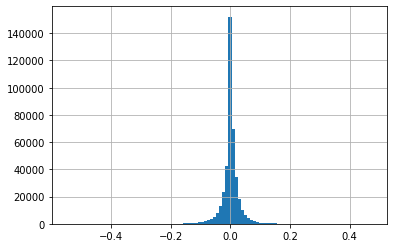

In [35]:
result['diff'] = (y_pred - y_test)
result['diff'].hist(bins=100)

In [43]:
bad = result[np.abs(result['diff']) >= result['diff'].std() * 3]
good = result[np.abs(result['diff']) <= 0.001]

In [40]:
bad['geohash6'].value_counts()[:10]

qp06pm    253
qp03r0    247
qp03pc    224
qp06nv    214
qp03qg    214
qp03r9    207
qp08b7    173
qp03ny    171
qp03pt    155
qp09h7    149
Name: geohash6, dtype: int64

In [44]:
good['geohash6'].value_counts()[:10]

qp0d0g    1260
qp02z9    1222
qp0d4v    1132
qp09fq    1124
qp0d4c    1068
qp08cp     995
qp09dr     964
qp02zm     907
qp09fh     860
qp09f3     849
Name: geohash6, dtype: int64

In [58]:
bad['label_km10'].value_counts()

0    4973
5    1632
3    1205
8     885
7     214
4     149
6      68
9       3
1       3
Name: label_km10, dtype: int64

In [59]:
good['label_km10'].value_counts()

0    36463
5    19773
8     9701
3     5002
9     1713
4     1418
6      892
1      233
7       59
2       58
Name: label_km10, dtype: int64

# >>> examination
# >>> use lat/lon, how to add more spatial features?
goods are not necessarily as good as you thought, bad are not as bad, why?
- zeros are easy to get
- some good ones are at very small scale

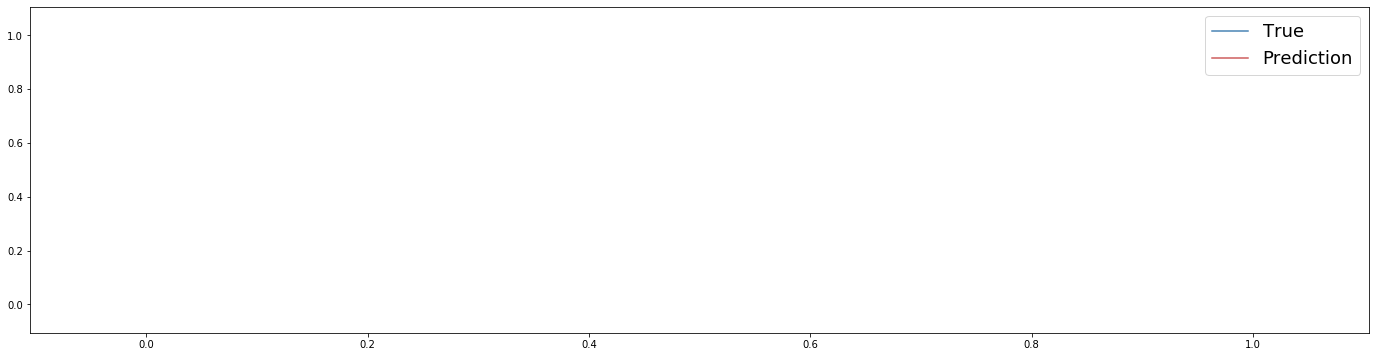

In [57]:
# good and bad
gh = 'label_km10'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

In [270]:
# result[result['label_km9_x'] == i].head()
result[result['label_km10'] == i]['geohash6'].unique()[:10]

array(['qp03p2', 'qp03qf', 'qp03qj', 'qp03qm', 'qp03we', 'qp03wy',
       'qp03x5', 'qp03xh', 'qp03xs', 'qp03xv'], dtype=object)

# >>> surge prediction is often off
# >>> cap output at (0,1)
# remove outliers for training?
remove demand < 10 (actual) as suggested by AAAI 2018
# sanity check undone

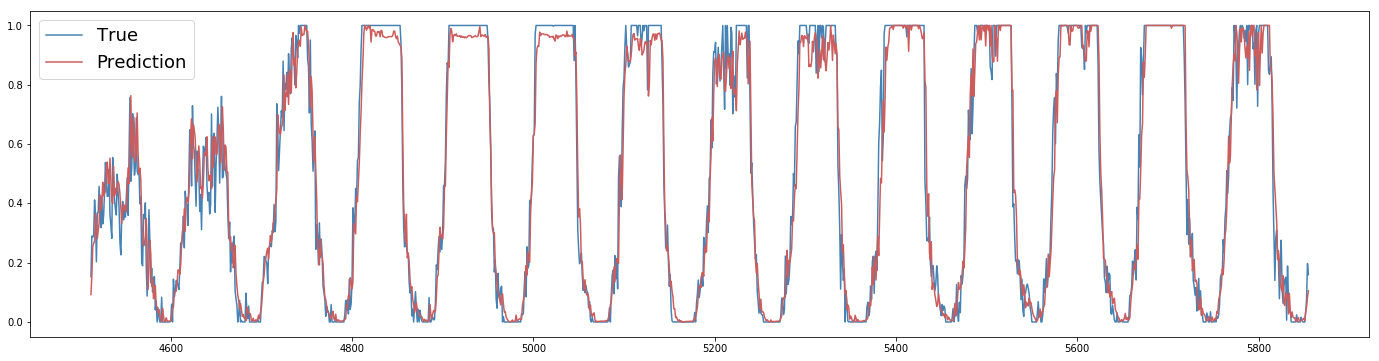

In [236]:
# t-1, t-5, t-1D, t-7D (new full_df) capping
gh = 'qp02zz'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

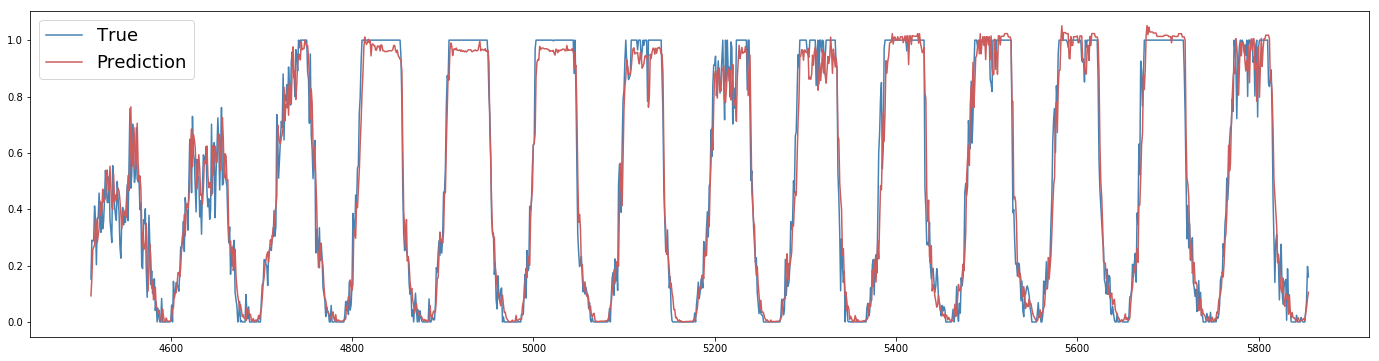

In [221]:
# t-1, t-5, t-1D, t-7D (new full_df)
gh = 'qp02zz'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

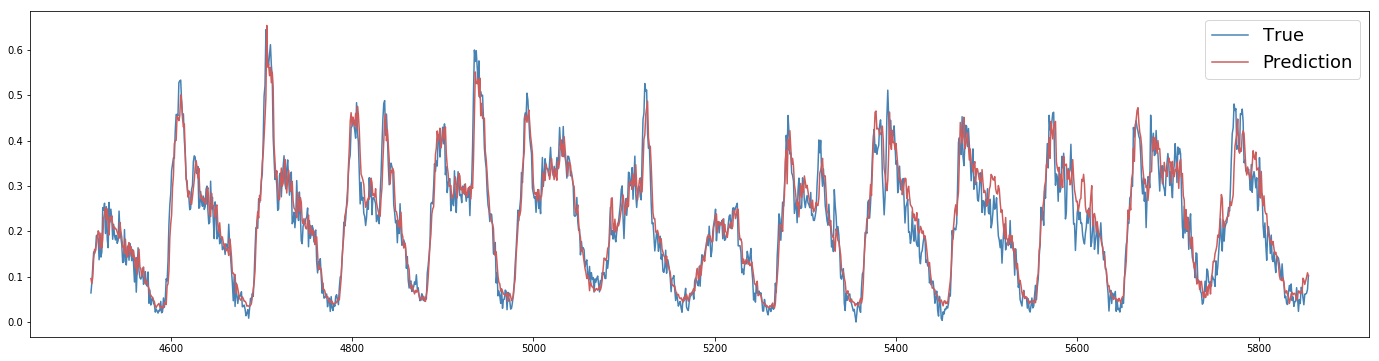

In [255]:
# new full_df all (i=4)
gh = 'qp03x5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

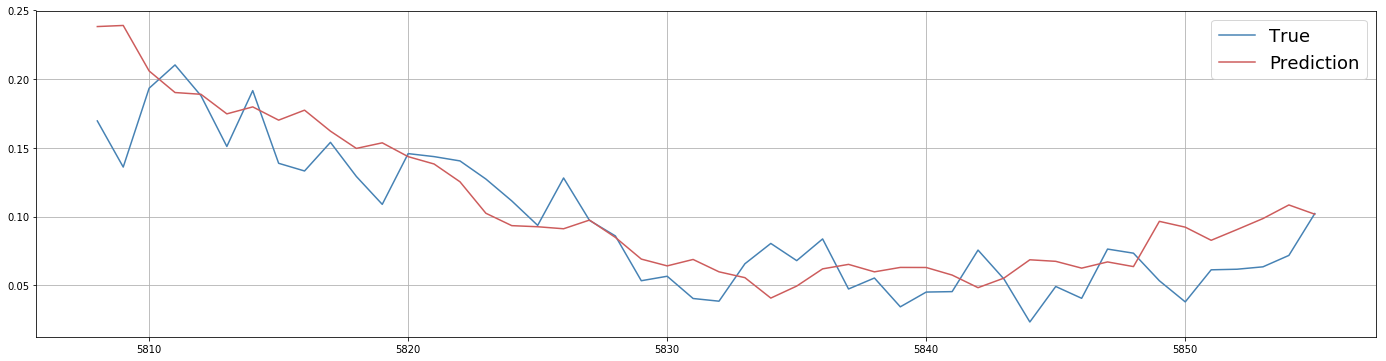

In [258]:
# new full_df all (i=4)
gh = 'qp03x5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'][-48:], sample['y_test'][-48:], color='steelblue', label='True')
ax.plot(sample['timestep'][-48:], sample['y_pred'][-48:], color='indianred', label='Prediction')
plt.legend(fontsize=18)
plt.grid()

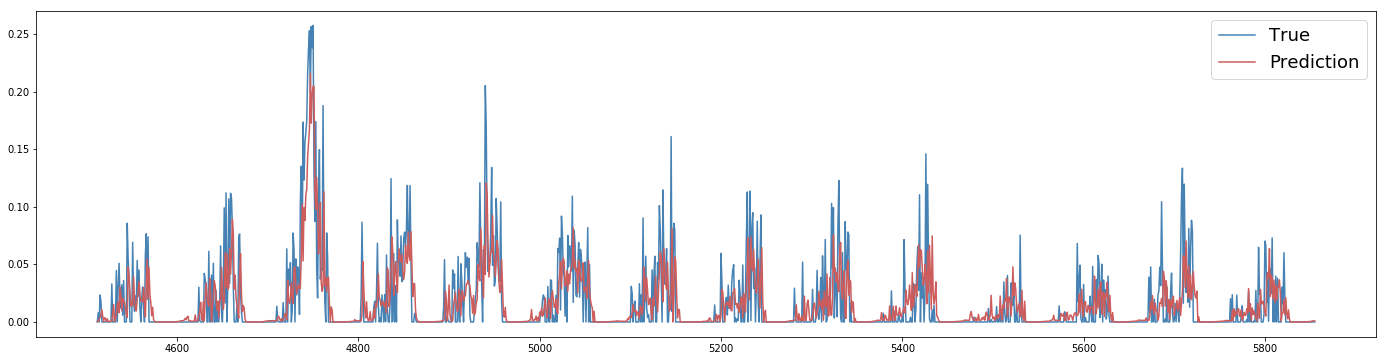

In [237]:
# t-1, t-5, t-1D, t-7D (new full_df)
gh = 'qp02z5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

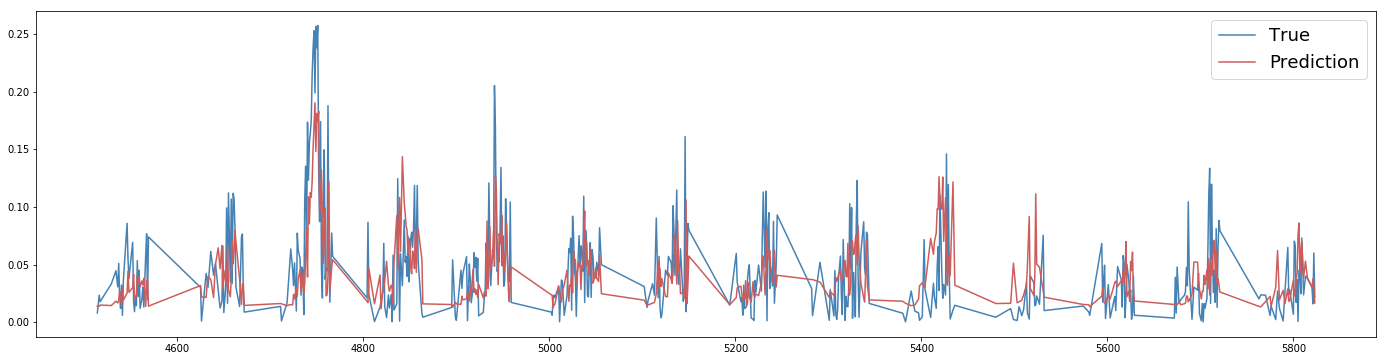

In [269]:
# t-1, t-5, t-1D, t-7D
gh = 'qp02z5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

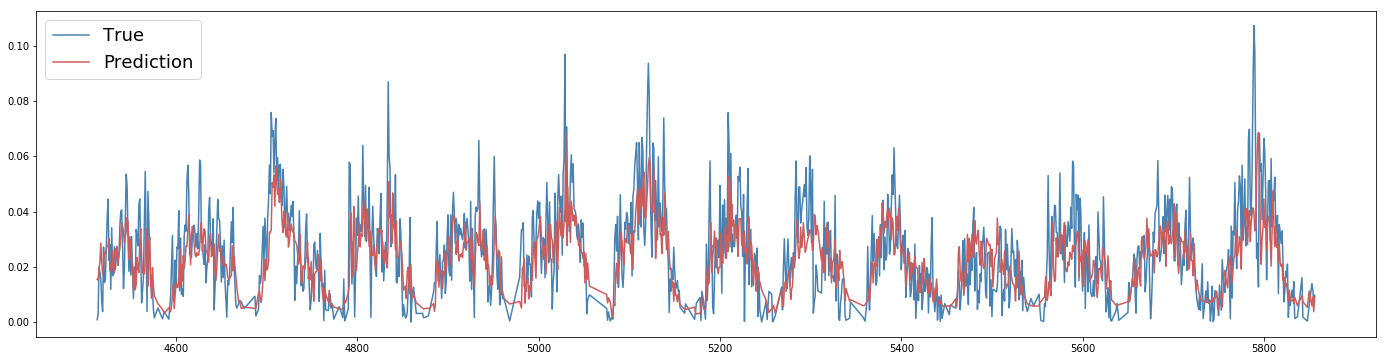

In [97]:
# t-1, t-5, t-1D, t-7D, weekend, st_trend (km_label_x == 0)
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

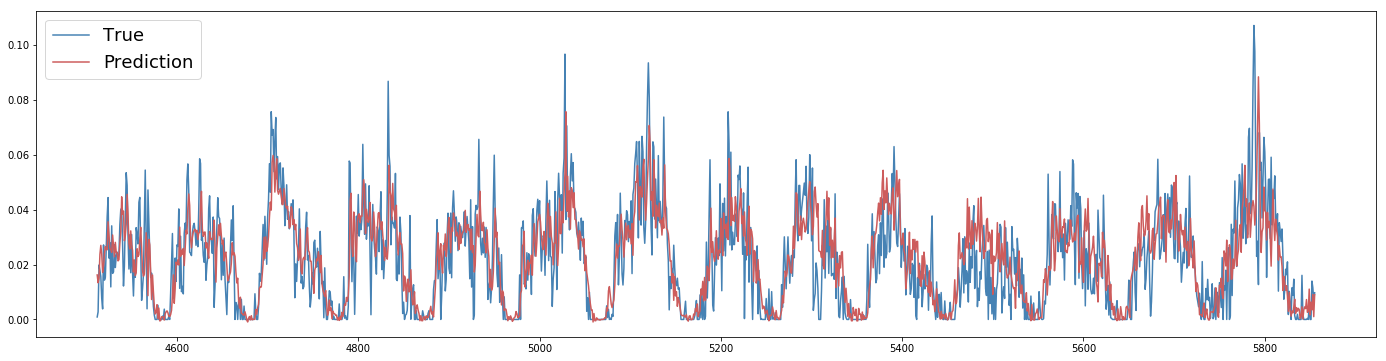

In [92]:
# t-1, t-5, t-1D, t-7D, weekend (new full_df)
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

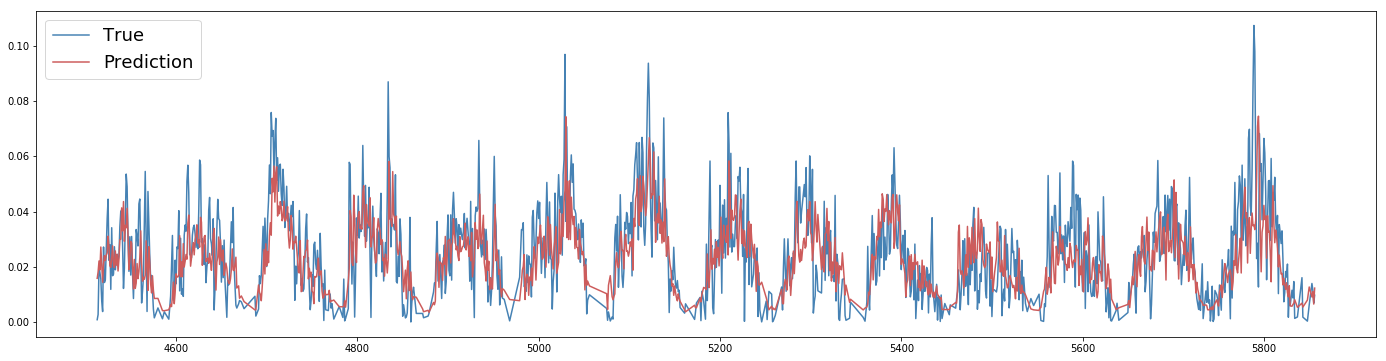

In [60]:
# t-1, t-5, t-1D, t-7D, weekend
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

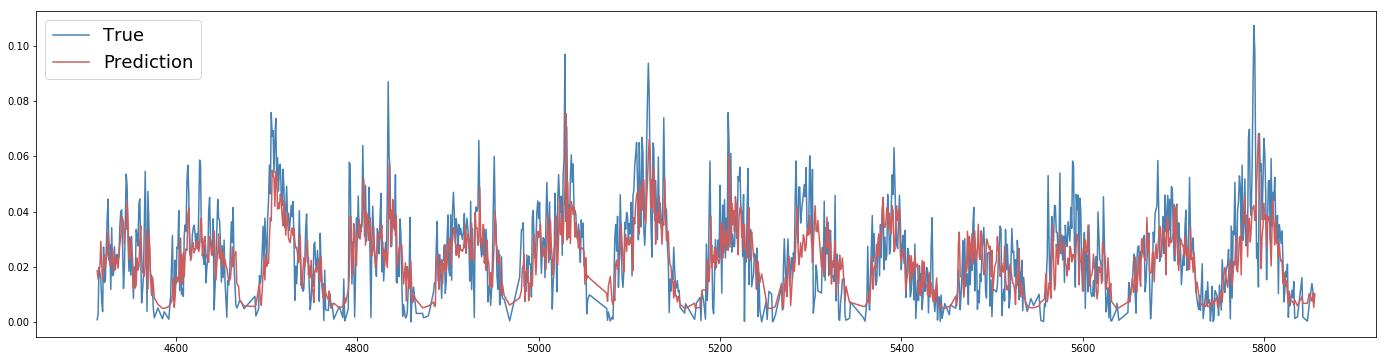

In [256]:
# t-1, t-5, t-1D, t-7D (km_label_x == 0)
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

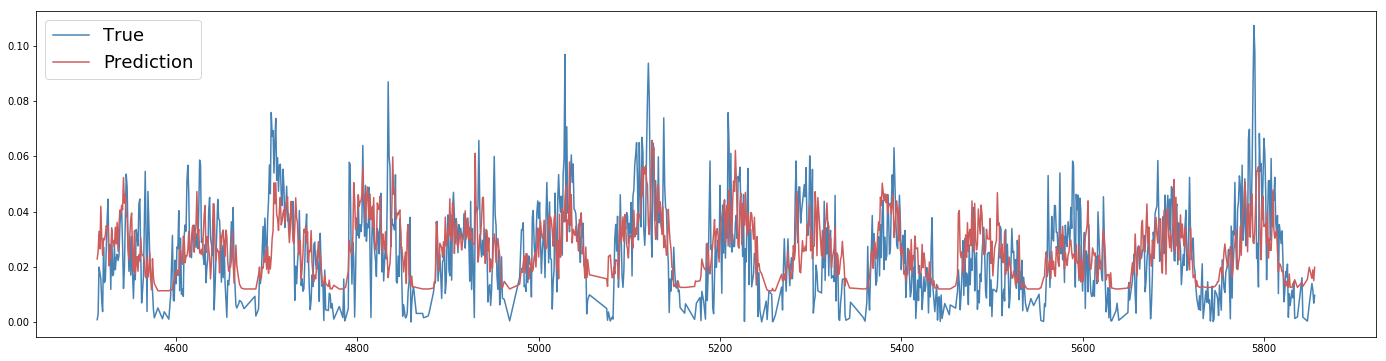

In [220]:
# t-5, t-1D, t-7D
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

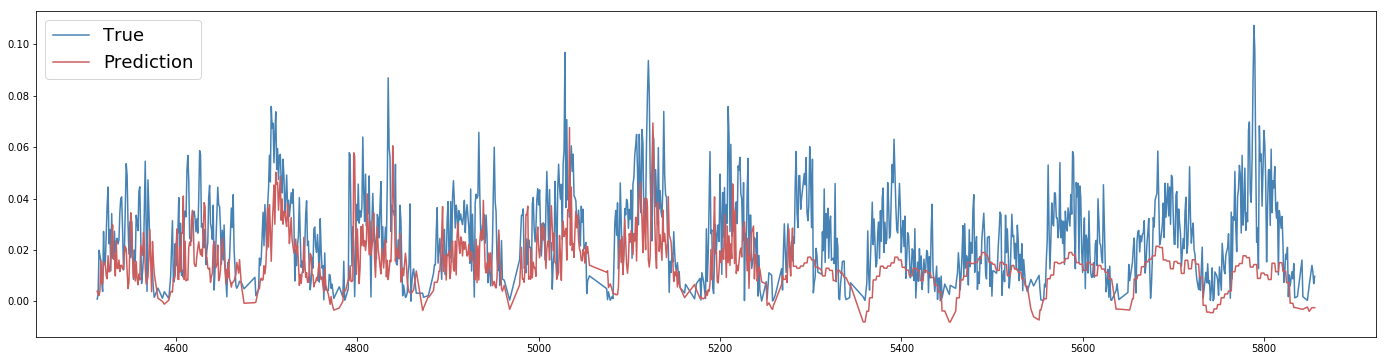

In [176]:
# clustering as cate
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

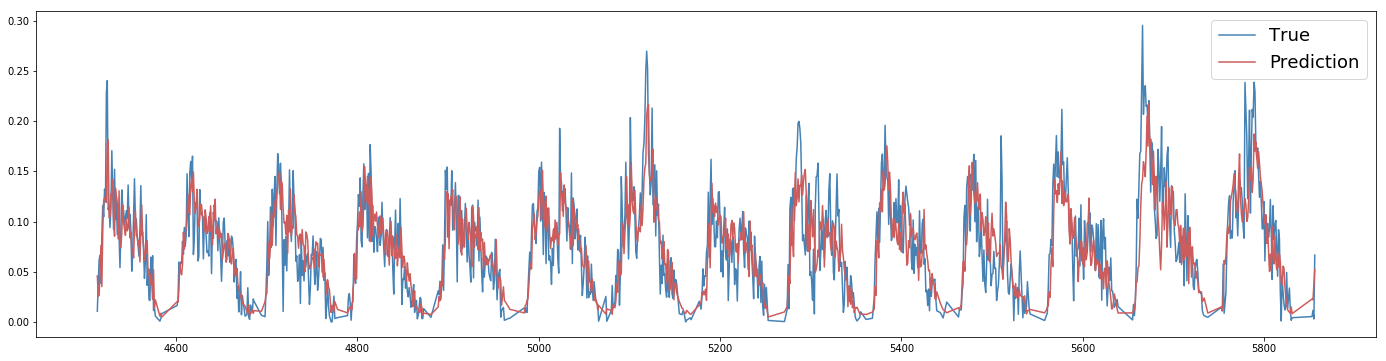

In [231]:
# t-1, t-5, t-1D, t-7D
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

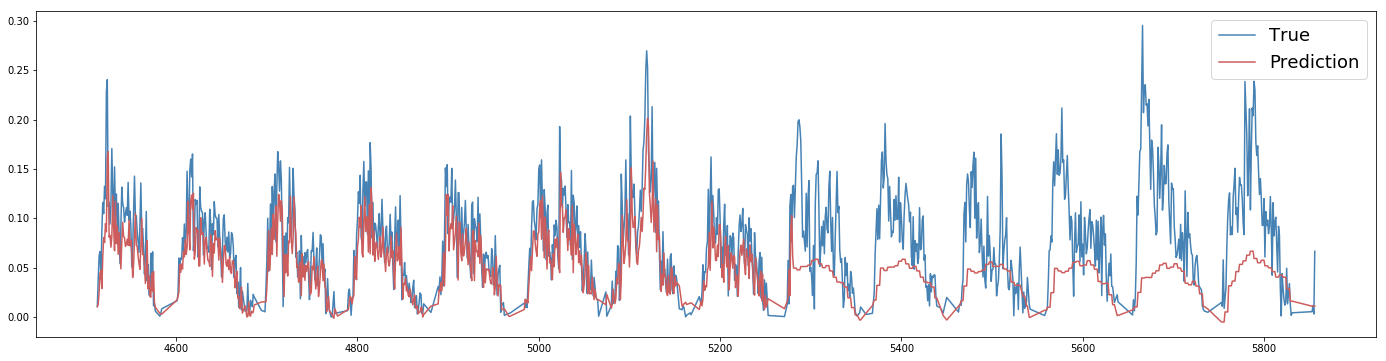

In [160]:
# clustering as cate
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

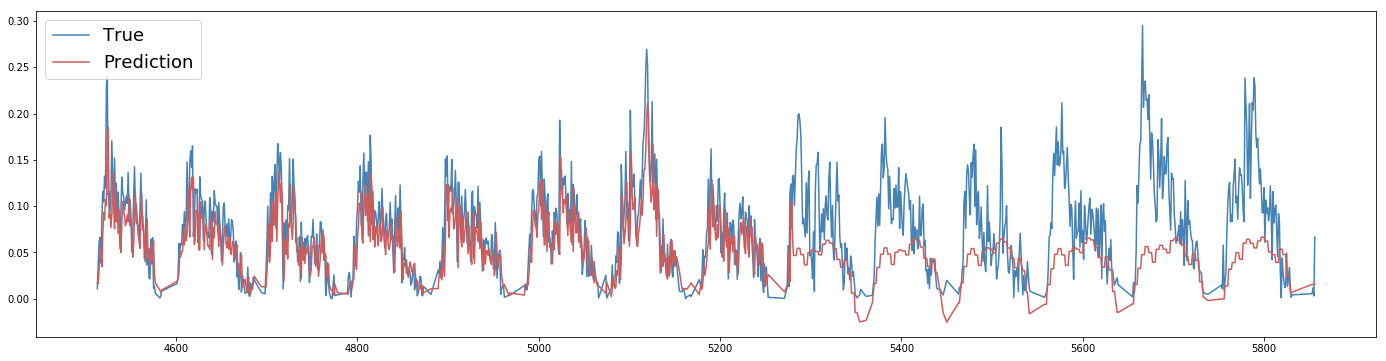

In [128]:
# dow as cate
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

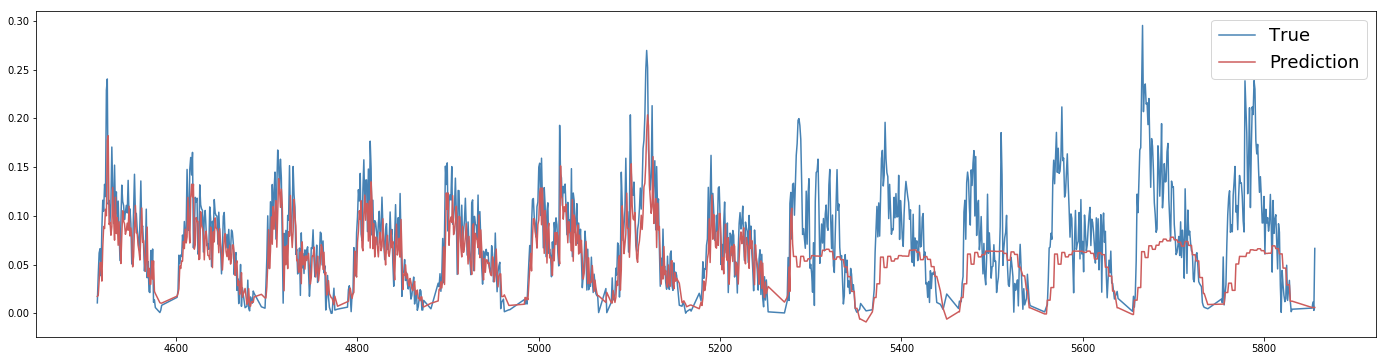

In [123]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

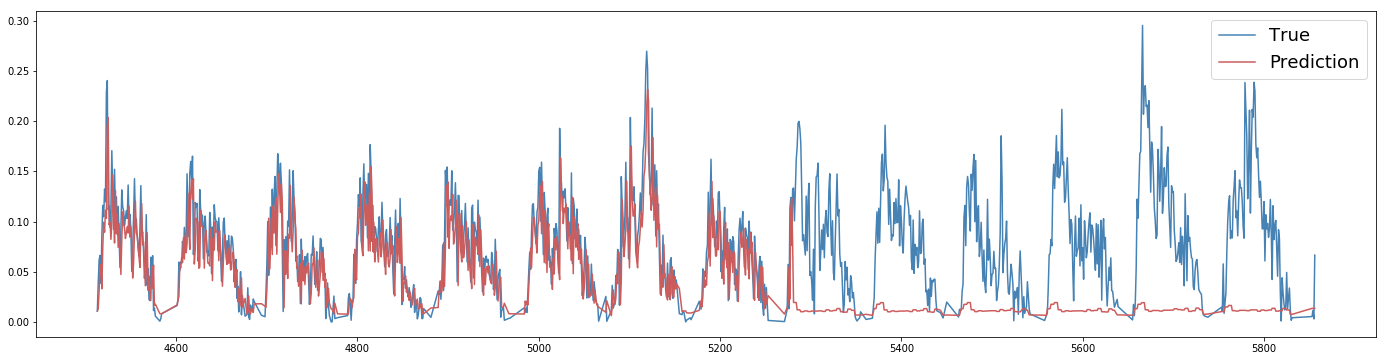

In [110]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

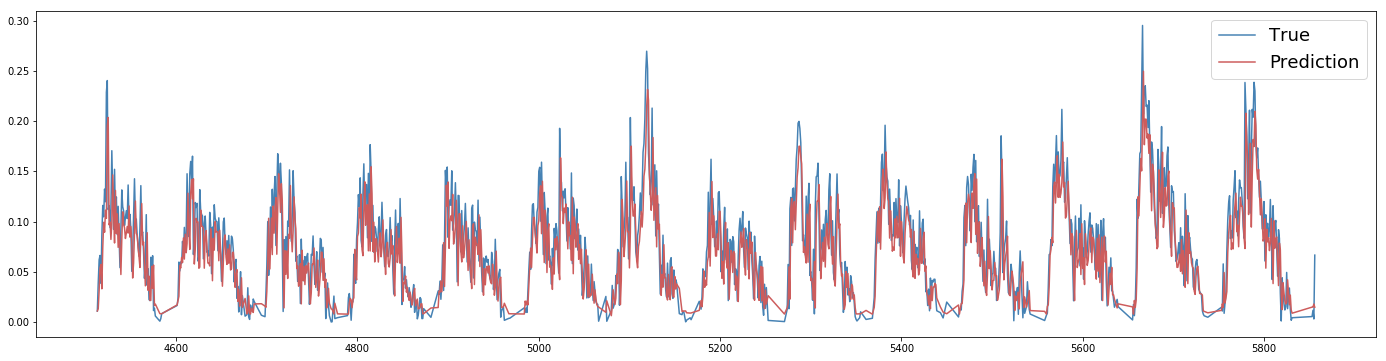

In [102]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

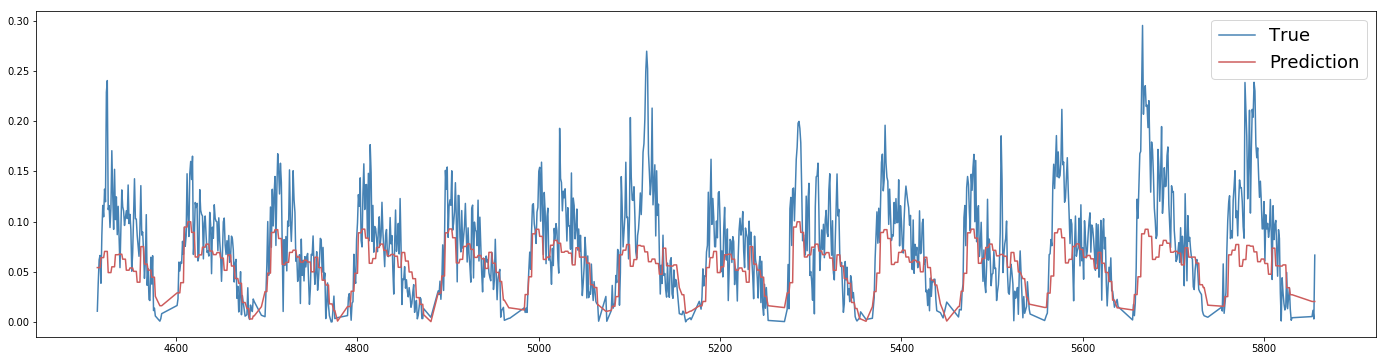

In [70]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

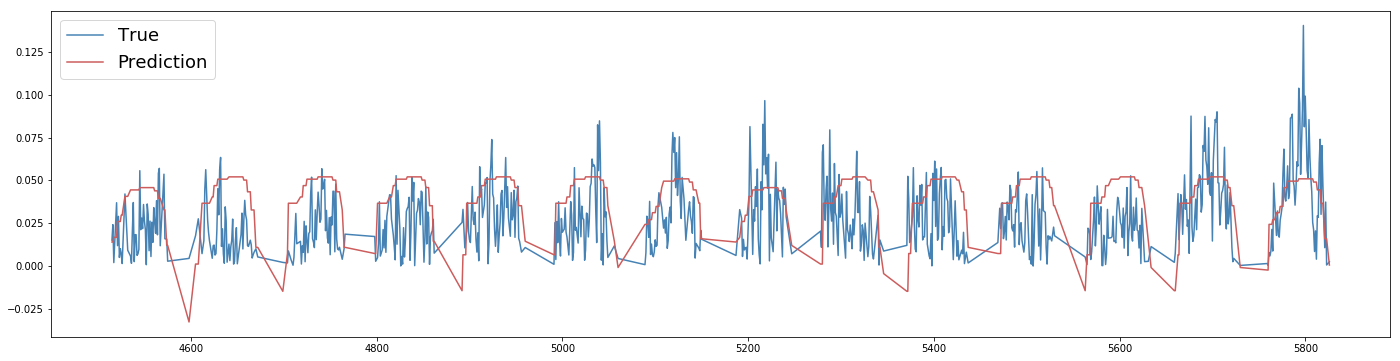

In [148]:
gh = 'qp091w'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

In [ ]:
"""LGBM Starter

This is watered-down version of one of my earlier scripts. 
Only very basic features are retained so hopefully it won't ruin the fun for you.
"""
from datetime import date, timedelta

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

df_train = pd.read_csv(
    '../input/train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_test = pd.read_csv(
    "../input/test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

items = pd.read_csv(
    "../input/items.csv",
).set_index("item_nbr")

df_2017 = df_train[df_train.date.isin(
    pd.date_range("2017-05-31", periods=7 * 11))].copy()
del df_train

promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train

df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

items = items.reindex(df_2017.index.get_level_values(1))

def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

print("Preparing dataset...")
t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

print("Training and predicting models...")
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression_l2',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * 4) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb.csv', float_format='%.4f', index=None)


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())